In [2]:
import os
from glob import glob

from astropy.io import fits, ascii
from astropy.table import Table, hstack

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


plt.rcParams.update({
    'font.family'      :'serif',
    'font.size'        : 24,
    'font.serif'       :'Georgia',
    'axes.labelsize'   :'large',
    'mathtext.fontset' :'stix',
    'axes.linewidth'   :  1.5,
    'xtick.direction'  :'in',
    'ytick.direction'  :'in',
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
})

def Table_to_array(table):
    tuple_data = table.as_array()
    list_data  = [list(values) for values in tuple_data]
    array_data = np.array(list_data, dtype = np.float32)

    return array_data

In [3]:
with fits.open('/data2/lsajkov/mpdg/data_products/predicted_catalogs/KiDS_SOM_r50_01Aug24.fits') as cat:
    KiDS_predicted = Table(cat[1].data)

In [4]:
labeled_map = np.load('/data2/lsajkov/mpdg/saved_soms/31Jul24_cosmos/labeled_map.npy',
                      allow_pickle = True)
labeled_map_values = np.load('/data2/lsajkov/mpdg/saved_soms/31Jul24_cosmos/labeled_map_values.npy',
                      allow_pickle = True)
data_bmus = np.load('/data2/lsajkov/mpdg/saved_soms/31Jul24_cosmos/data_bmus.npy',
                      allow_pickle = True)
labeling_bmus = np.load('/data2/lsajkov/mpdg/saved_soms/31Jul24_cosmos/labeling_bmus.npy',
                      allow_pickle = True)

In [5]:
steps = 250
min_z = 0; max_z = 0.4
min_mstar = 6; max_mstar = 12

In [6]:
def gauss(x, mu, sigma): return 1/np.sqrt(2 * np.pi * sigma**2) * np.exp(-(x - mu)**2/(2 * sigma**2))

Text(0.5, 0, '$z$')

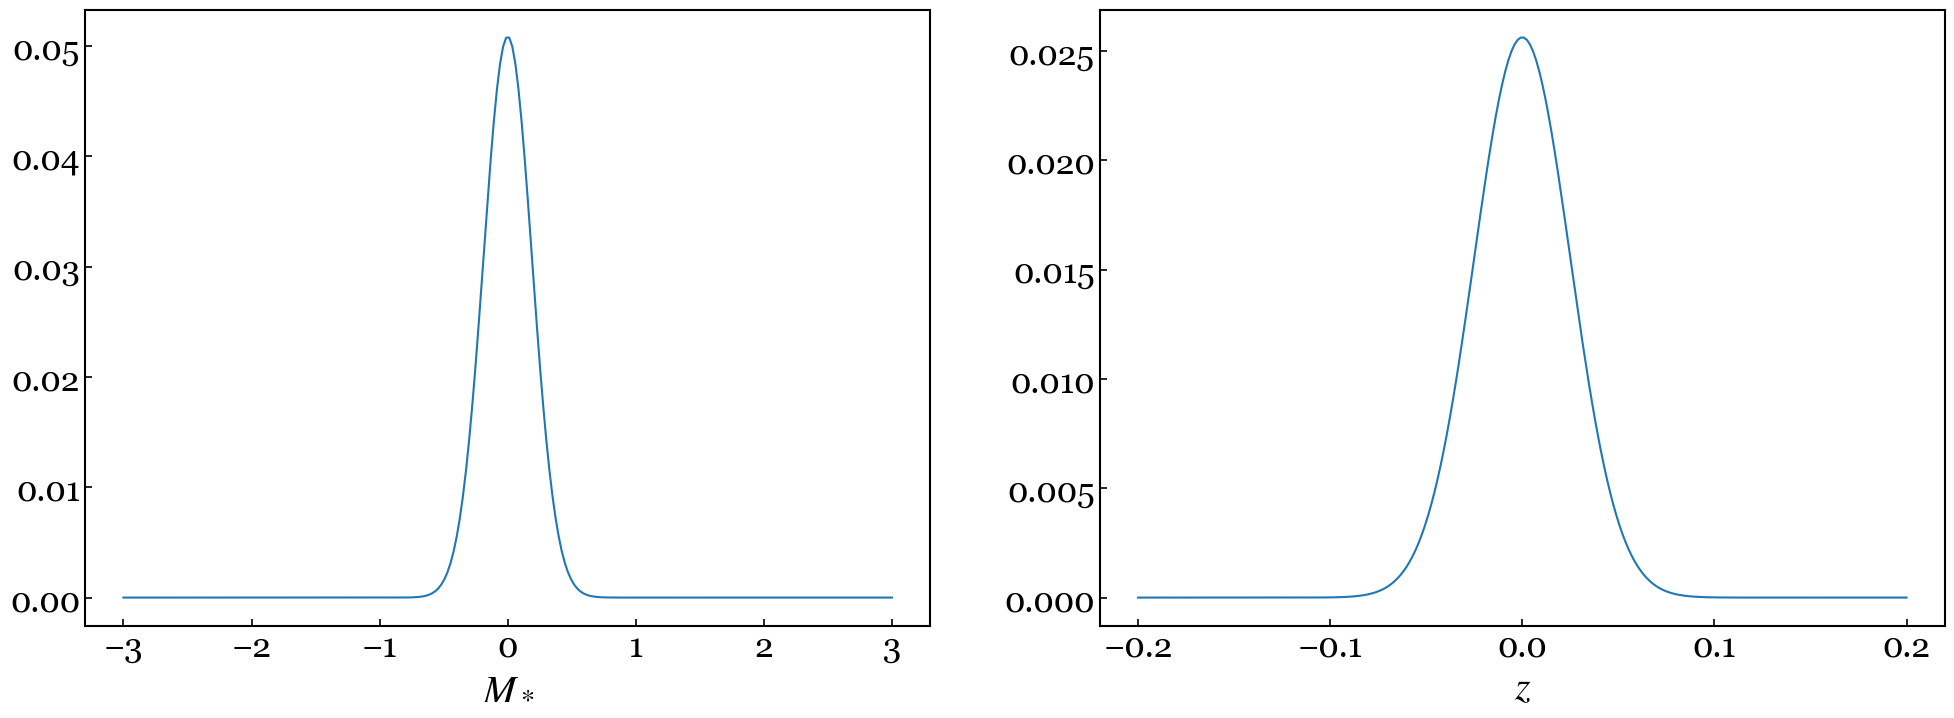

In [7]:
redshift_sigma = 0.025
redshift_gaussian = 1/np.sqrt(2 * np.pi * redshift_sigma ** 2) *\
                    np.exp(-(np.linspace(min_z, max_z, steps) - (max_z - min_z)/2) ** 2/(2 * redshift_sigma**2))
redshift_gaussian /= np.sum(redshift_gaussian)

mstar_sigma = 0.189
mstar_gaussian = 1/np.sqrt(2 * np.pi * mstar_sigma ** 2) *\
                 np.exp(-(np.linspace(min_mstar, max_mstar, steps) - (max_mstar + min_mstar)/2) ** 2/(2 * mstar_sigma**2))
mstar_gaussian /= np.sum(mstar_gaussian)

fig = plt.figure(figsize = (24, 8))
ax_l = fig.add_subplot(121)
ax_l.plot(np.linspace(min_mstar, max_mstar, steps) - (max_mstar + min_mstar)/2, mstar_gaussian)
ax_l.set_xlabel('$M_*$')

ax_r = fig.add_subplot(122)
ax_r.plot(np.linspace(min_z, max_z, steps) - (min_z + max_z)/2, redshift_gaussian)
ax_r.set_xlabel('$z$')

In [8]:
mstar_lo = labeled_map[..., 1] < 8.75
mstar_md = (labeled_map[..., 1] >= 8.75) & (labeled_map[..., 1] < 9.5)
mstar_hi = labeled_map[..., 1] >= 9.5

In [9]:
#mstar lo bin
#redshift
mstar_lo_zs = labeled_map_values[mstar_lo, 0]
mstar_lo_z_dist = np.zeros(steps)

weights = np.array([])
for cell in mstar_lo_zs:
    values = np.histogram(cell, bins = np.linspace(min_z, max_z, steps))[0]
    dist_in_cell = np.convolve(values, redshift_gaussian/np.sum(redshift_gaussian), mode = 'same')
    weight_in_cell = len(cell)
    mstar_lo_z_dist += dist_in_cell * weight_in_cell
    weights = np.append(weights, weight_in_cell)

mstar_lo_z_dist /= np.sum(weights)

#mstar
mstar_lo_mstars = labeled_map_values[mstar_lo, 1]
mstar_lo_mstar_dist = np.zeros(steps)

weights = np.array([])
for cell in mstar_lo_mstars:
    values = np.histogram(np.log10(cell), bins = np.linspace(min_mstar, max_mstar, steps))[0]
    dist_in_cell = np.convolve(values, mstar_gaussian/np.sum(mstar_gaussian), mode = 'same')
    weight_in_cell = len(cell)
    mstar_lo_mstar_dist += dist_in_cell * weight_in_cell
    weights = np.append(weights, weight_in_cell)

mstar_lo_mstar_dist /= np.sum(weights)

In [10]:
#mstar md bin
#redshift
mstar_md_zs = labeled_map_values[mstar_md, 0]
mstar_md_z_dist = np.zeros(steps)

weights = np.array([])
for cell in mstar_md_zs:
    values = np.histogram(cell, bins = np.linspace(min_z, max_z, steps))[0]
    dist_in_cell = np.convolve(values, redshift_gaussian/np.sum(redshift_gaussian), mode = 'same')
    weight_in_cell = len(cell)
    mstar_md_z_dist += dist_in_cell * weight_in_cell
    weights = np.append(weights, weight_in_cell)

mstar_md_z_dist /= np.sum(weights)

#mstar
mstar_md_mstars = labeled_map_values[mstar_md, 1]
mstar_md_mstar_dist = np.zeros(steps)

weights = np.array([])
for cell in mstar_md_mstars:
    values = np.histogram(np.log10(cell), bins = np.linspace(min_mstar, max_mstar, steps))[0]
    dist_in_cell = np.convolve(values, mstar_gaussian/np.sum(mstar_gaussian), mode = 'same')
    weight_in_cell = len(cell)
    mstar_md_mstar_dist += dist_in_cell * weight_in_cell
    weights = np.append(weights, weight_in_cell)

mstar_md_mstar_dist /= np.sum(weights)

In [11]:
#mstar hi bin
#redshift
mstar_hi_zs = labeled_map_values[mstar_hi, 0]
mstar_hi_z_dist = np.zeros(steps)

weights = np.array([])
for cell in mstar_hi_zs:
    values = np.histogram(cell, bins = np.linspace(min_z, max_z, steps))[0]
    dist_in_cell = np.convolve(values, redshift_gaussian/np.sum(redshift_gaussian), mode = 'same')
    weight_in_cell = len(cell)
    mstar_hi_z_dist += dist_in_cell * weight_in_cell
    weights = np.append(weights, weight_in_cell)

mstar_hi_z_dist /= np.sum(weights)

#mstar
mstar_hi_mstars = labeled_map_values[mstar_hi, 1]
mstar_hi_mstar_dist = np.zeros(steps)

weights = np.array([])
for cell in mstar_hi_mstars:
    values = np.histogram(np.log10(cell), bins = np.linspace(min_mstar, max_mstar, steps))[0]
    dist_in_cell = np.convolve(values, mstar_gaussian/np.sum(mstar_gaussian), mode = 'same')
    weight_in_cell = len(cell)
    mstar_hi_mstar_dist += dist_in_cell * weight_in_cell
    weights = np.append(weights, weight_in_cell)

mstar_hi_mstar_dist /= np.sum(weights)

In [12]:
x_z = np.linspace(min_z, max_z, steps)
z_pdf_lo = mstar_lo_z_dist/np.sum(mstar_lo_z_dist)
z_exp_lo = np.dot(x_z, z_pdf_lo)

z_pdf_md = mstar_md_z_dist/np.sum(mstar_md_z_dist)
z_exp_md = np.dot(x_z, z_pdf_md)

z_pdf_hi = mstar_hi_z_dist/np.sum(mstar_hi_z_dist)
z_exp_hi = np.dot(x_z, z_pdf_hi)

x_mstar = np.linspace(min_mstar, max_mstar, steps)
mstar_pdf_lo = mstar_lo_mstar_dist/np.sum(mstar_lo_mstar_dist)
mstar_exp_lo = np.dot(x_mstar, mstar_pdf_lo)

mstar_pdf_md = mstar_md_mstar_dist/np.sum(mstar_md_mstar_dist)
mstar_exp_md = np.dot(x_mstar, mstar_pdf_md)

mstar_pdf_hi = mstar_hi_mstar_dist/np.sum(mstar_hi_mstar_dist)
mstar_exp_hi = np.dot(x_mstar, mstar_pdf_hi)

<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
/var/tmp/lsajkov/ipykernel_849893/4168645425.py:34: SyntaxWarning: invalid escape sequence '\l'
  ax_r.set_xlabel('$\log_{10}(M_*/M_{\odot})$')
/var/tmp/lsajkov/ipykernel_849893/4168645425.py:35: SyntaxWarning: invalid escape sequence '\l'
  ax_r.set_ylabel('$p(\log_{10}(M_*/M_{\odot}))$')


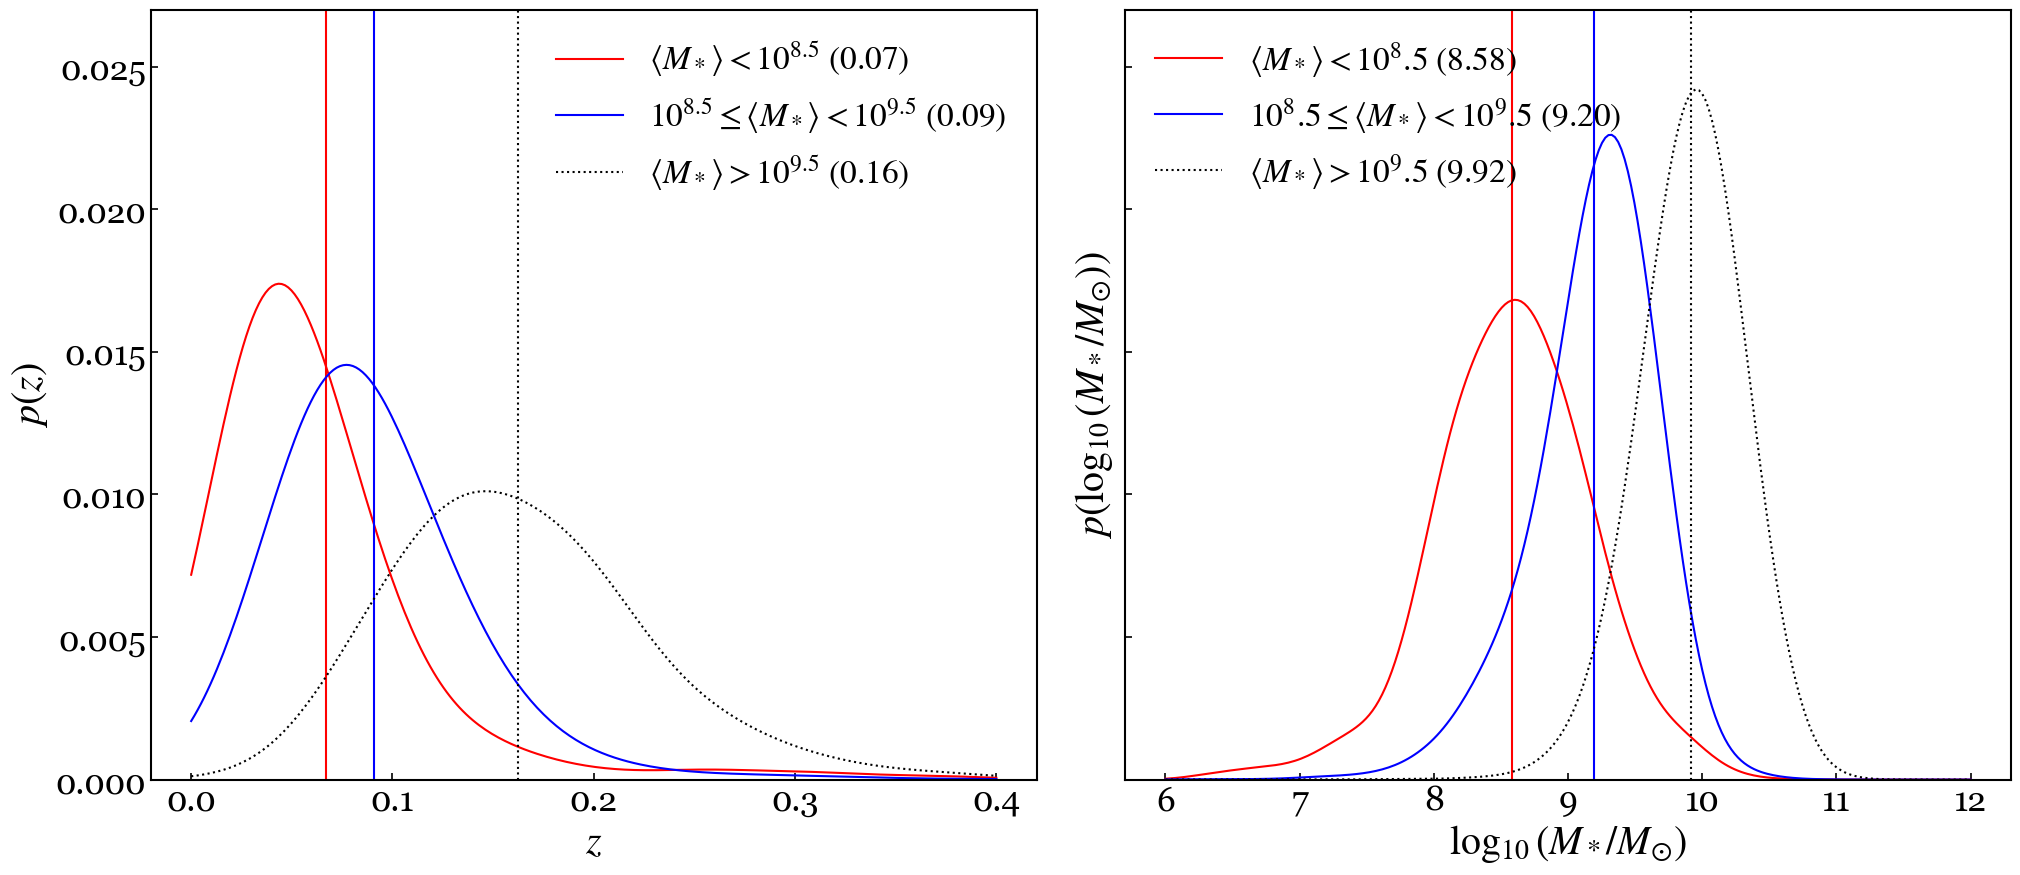

In [13]:
fig = plt.figure(figsize = (24, 10))
ax_l = fig.add_subplot(121)

ax_l.plot(x_z, z_pdf_lo, color = 'red', label = rf'$\langle M_* \rangle < 10^{{8.5}}\ ({z_exp_lo:.2f})$')
ax_l.axvline(z_exp_lo, color = 'red')

ax_l.plot(x_z, z_pdf_md, color = 'blue', label = rf'$10^{{8.5}} \leq \langle M_* \rangle < 10^{{9.5}}\ ({z_exp_md:.2f})$')
ax_l.axvline(z_exp_md, color = 'blue')

ax_l.plot(x_z, z_pdf_hi, color = 'black', linestyle = ':', label = rf'$\langle M_* \rangle > 10^{{9.5}}\ ({z_exp_hi:.2f})$')
ax_l.axvline(z_exp_hi, color = 'black', linestyle = ':')

ax_l.set_ylim(0, 0.027)

ax_l.set_xlabel('$z$')
ax_l.set_ylabel('$p(z)$')

ax_l.legend(frameon = False)

ax_r = fig.add_subplot(122)

ax_r.plot(x_mstar, mstar_pdf_lo, color = 'red', label = rf'$\langle M_* \rangle < 10^{8.5}\ ({mstar_exp_lo:.2f})$')
ax_r.axvline(mstar_exp_lo, color = 'red')

ax_r.plot(x_mstar, mstar_pdf_md, color = 'blue', label = rf'$10^{8.5} \leq \langle M_* \rangle < 10^{9.5}\ ({mstar_exp_md:.2f})$')
ax_r.axvline(mstar_exp_md, color = 'blue')

ax_r.plot(x_mstar, mstar_pdf_hi, color = 'black', linestyle = ':', label = fr'$\langle M_* \rangle > 10^{9.5}\ ({mstar_exp_hi:.2f})$')
ax_r.axvline(mstar_exp_hi, color = 'black', linestyle = ':')

ax_r.set_ylim(0, 0.027)
ax_r.set_yticklabels([])

ax_r.set_xlabel('$\log_{10}(M_*/M_{\odot})$')
ax_r.set_ylabel('$p(\log_{10}(M_*/M_{\odot}))$')

ax_r.legend(frameon = False)

fig.subplots_adjust(wspace = 0.1)

In [ ]:
#check if we have as many bmus as we have data pointsb
len(data_bmus) == len(training_data)

In [ ]:
len(KiDS_predicted) == len(training_data)

In [64]:
# mstar_lo_idx = np.all(np.any(mstar_lo[data_bmus], axis = -1), axis = -1)
# mstar_md_idx = np.all(np.any(mstar_md[data_bmus], axis = -1), axis = -1)
# mstar_hi_idx = np.all(np.any(mstar_hi[data_bmus], axis = -1), axis = -1)

mstar_lo_idx = [mstar_lo[*index] for index in data_bmus]
mstar_md_idx = [mstar_md[*index] for index in data_bmus]
mstar_hi_idx = [mstar_hi[*index] for index in data_bmus]

In [65]:
mstar_lo_catalog = KiDS_predicted[mstar_lo_idx]
mstar_md_catalog = KiDS_predicted[mstar_md_idx]
mstar_hi_catalog = KiDS_predicted[mstar_hi_idx]

# mstar_lo_catalog.write('/data2/lsajkov/mpdg/data_products/predicted_catalogs/KiDS_mstar_lo_bin_31Jul24.fits')
# mstar_lo_catalog.write('/data2/lsajkov/mpdg/data_products/predicted_catalogs/KiDS_mstar_md_bin_31Jul24.fits')
# mstar_lo_catalog.write('/data2/lsajkov/mpdg/data_products/predicted_catalogs/KiDS_mstar_hi_bin_31Jul24.fits')

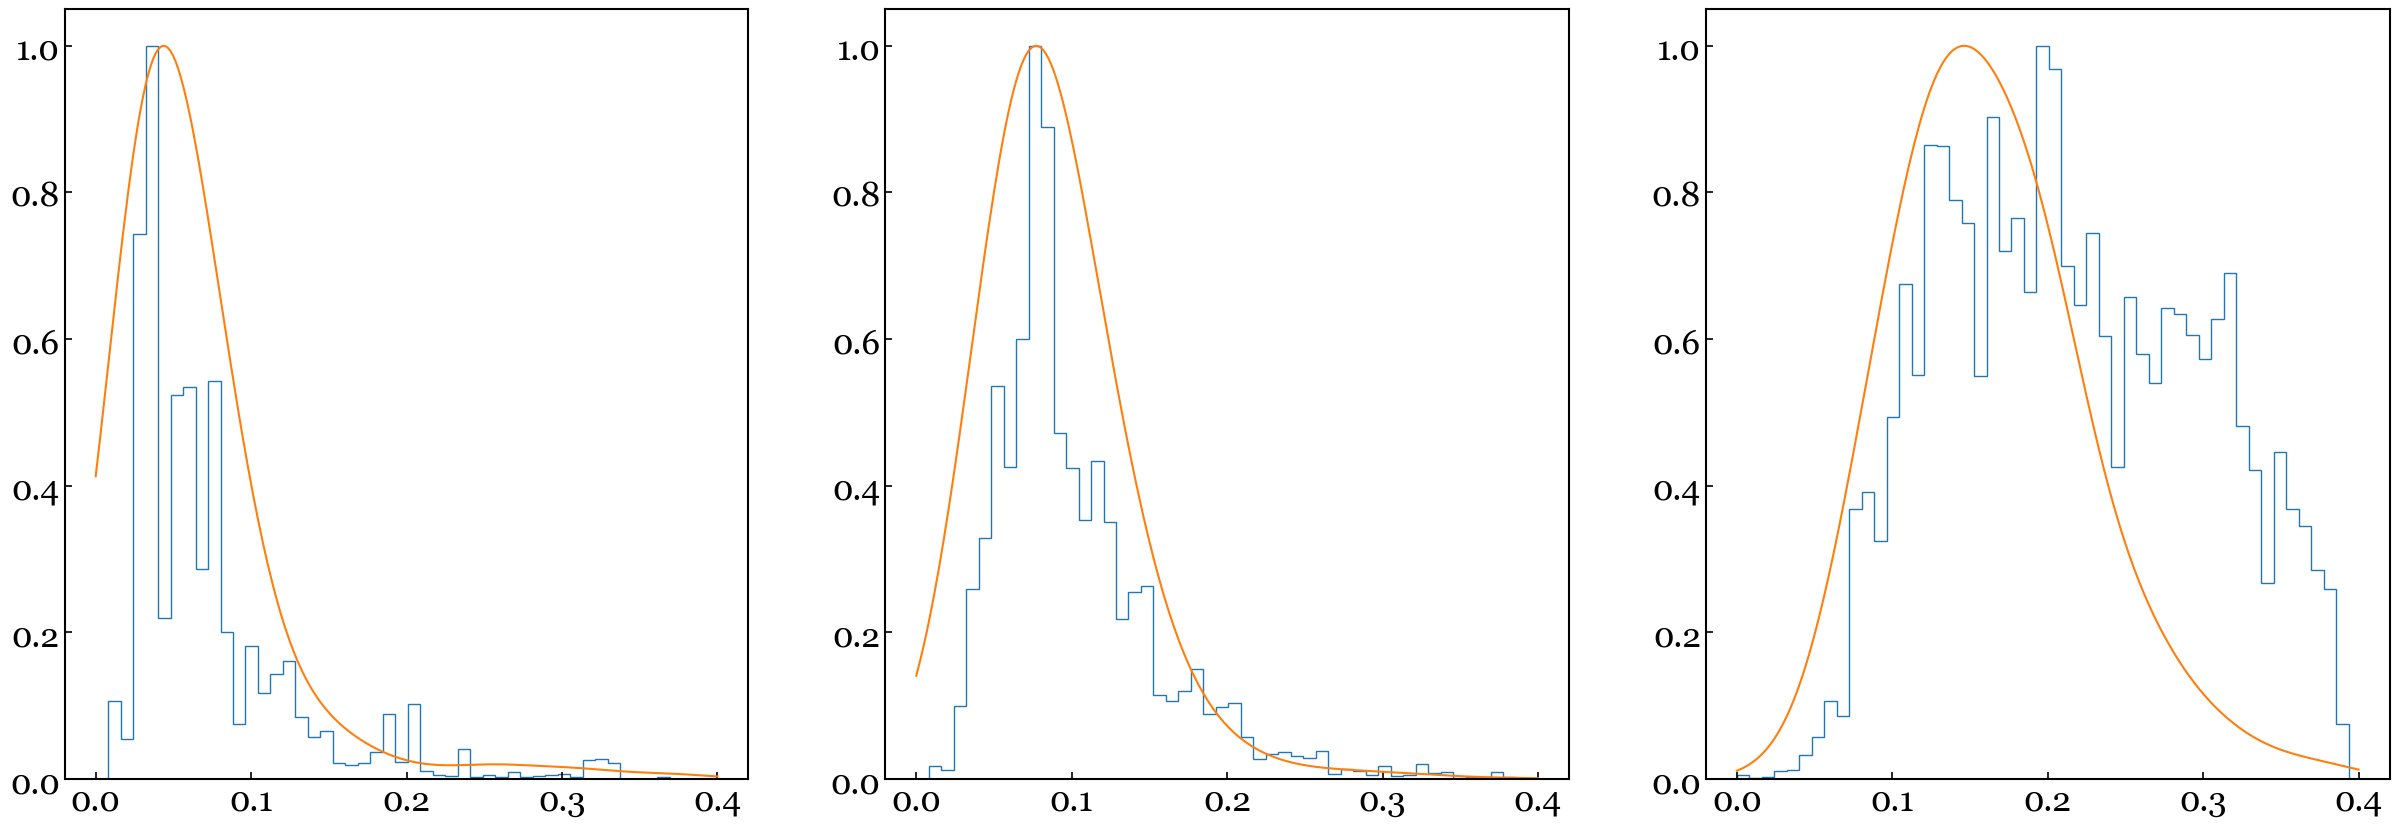

In [88]:
fig = plt.figure(figsize = (30, 10))

bins = mstar_lo_n_z[:, 0][::5]
ax_l = fig.add_subplot(131)

vals = np.histogram(mstar_lo_catalog['redshift_pred'], bins = bins)[0]
ax_l.stairs(vals/np.max(vals), bins)
ax_l.plot(mstar_lo_n_z[:, 0], mstar_lo_n_z[:, 1]/np.max(mstar_lo_n_z[:, 1]))

ax_m = fig.add_subplot(132)

vals = np.histogram(mstar_md_catalog['redshift_pred'], bins = bins)[0]
ax_m.stairs(vals/np.max(vals), bins)
ax_m.plot(mstar_md_n_z[:, 0], mstar_md_n_z[:, 1]/np.max(mstar_md_n_z[:, 1]))

ax_r = fig.add_subplot(133)

vals = np.histogram(mstar_hi_catalog['redshift_pred'], bins = bins)[0]
ax_r.stairs(vals/np.max(vals), bins)
ax_r.plot(mstar_hi_n_z[:, 0], mstar_hi_n_z[:, 1]/np.max(mstar_hi_n_z[:, 1]))

# plt.hist(mstar_md_catalog['redshift_pred'], bins= 'auto', density = True)
# plt.hist(mstar_hi_catalog['redshift_pred'], bins= 'auto', density = True)

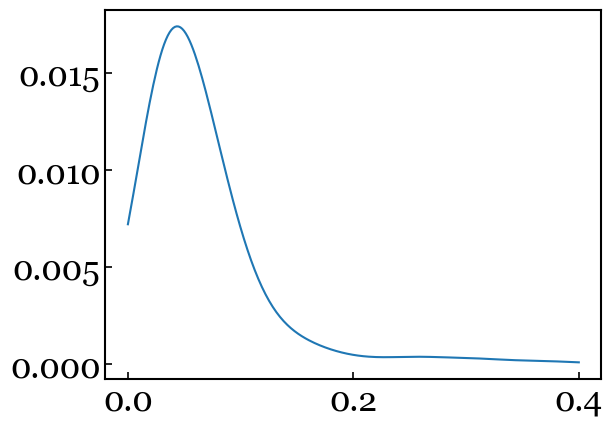

In [69]:
plt.plot(mstar_lo_n_z[:, 0], mstar_lo_n_z[:, 1])

In [62]:
mstar_lo_n_z = np.array(list(zip(x_z, z_pdf_lo)))
ascii.write(mstar_lo_n_z, '/data2/lsajkov/mpdg/data_products/KiDS/WL/n_z/mstar_lo_n_z')

mstar_md_n_z = np.array(list(zip(x_z, z_pdf_md)))
ascii.write(mstar_lo_n_z, '/data2/lsajkov/mpdg/data_products/KiDS/WL/n_z/mstar_md_n_z')

mstar_hi_n_z = np.array(list(zip(x_z, z_pdf_hi)))
ascii.write(mstar_lo_n_z, '/data2/lsajkov/mpdg/data_products/KiDS/WL/n_z/mstar_hi_n_z')